### Training and Data Collection

Required dependencies: `pygame`, `numpy`, `torch`, `opencv-python`, `psutil`, `py-cpuinfo`, `open3d`, `Pillow`, `networkx`.

Used packaged `Carla_0.10.0`(https://github.com/carla-simulator/carla/releases/tag/0.10.0) on `Python 3.12.X`.

"CARLA provides `.whl` files for different Python versions. You will need to install the `.whl` file. The `.whl` file is found in `PythonAPI/carla/dist/`. There is one file per supported Python version, indicated by the file name (e.g., carla-0.9.12-`cp36`-cp36m-manylinux_2_27_x86_64.whl indicates Python 3.6). To install the CARLA client library, run the following command, choosing the file appropriate to your desired Python version. You will need pip/pip3 version 20.3 or above.

`pip3 install <wheel-file-name>.whl`"

Assuming this notebook is in root directory of Carla, run following command on terminal to start Carla:

`.\CarlaUnreal.exe -carla-rpc-port=2000 -quality-level=Low -benchmark -fps=30`

This runs CARLA on port 2000, with low rendering option selected, and in fixed time-step 30fps (each step is 1/30 seconds).

In [ ]:
# Test if Carla is running on port 2000
import socket

def is_carla_running(host="localhost", port=2000, timeout=2):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        sock.settimeout(timeout)
        result = sock.connect_ex((host, port))
        return result == 0

if is_carla_running(): print("Carla simulator is running on port 2000!")
else:                  print("Carla simulator is NOT running on port 2000. Please start Carla and try again.")

In [ ]:
import carla
import random
import time
import math
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import heapq
import matplotlib.pyplot as plt
import os
import gc

#########################################
# 1. Environment Setup Functions
#########################################

def setup_carla_client():
    """
    Create and return a CARLA client and world.
    
    Returns:
        client: Carla client object.
        world: Carla world object.
    """
    client = carla.Client('localhost', 2000)
    client.set_timeout(10.0)
    world = client.get_world()
    return client, world

def spawn_vehicle(world):
    """
    Spawn a random vehicle in the given world.
    
    Parameters:
        world: Carla world object.
        
    Returns:
        vehicle: The spawned vehicle actor.
    """
    blueprint_library = world.get_blueprint_library()
    vehicle_bp = random.choice(blueprint_library.filter('vehicle.*'))
    spawn_points = world.get_map().get_spawn_points()
    spawn_point = random.choice(spawn_points)
    vehicle = world.spawn_actor(vehicle_bp, spawn_point)
    print("Vehicle spawned at:", spawn_point.location)
    return vehicle

def spawn_npc_vehicles(client, world, num_vehicles=10):
    """
    Spawn a specified number of NPC vehicles and set them to autopilot.
    
    Parameters:
        client: Carla client.
        world: Carla world object.
        num_vehicles: Number of NPC vehicles to spawn.
        
    Returns:
        npc_vehicles: List of spawned NPC vehicle actors.
    """
    blueprint_library = world.get_blueprint_library()
    spawn_points = world.get_map().get_spawn_points()
    random.shuffle(spawn_points)
    npc_vehicles = []
    for i in range(min(num_vehicles, len(spawn_points))):
        npc_bp = random.choice(blueprint_library.filter('vehicle.*'))
        npc_vehicle = world.try_spawn_actor(npc_bp, spawn_points[i])
        if npc_vehicle is not None:
            npc_vehicles.append(npc_vehicle)
    traffic_manager = client.get_trafficmanager(8000)
    for npc in npc_vehicles:
        npc.set_autopilot(True, traffic_manager.get_port())
    return npc_vehicles

def spawn_pedestrians(world, num_pedestrians=20):
    """
    Spawn a specified number of pedestrian actors.
    
    Parameters:
        world: Carla world object.
        num_pedestrians: Number of pedestrians to spawn.
        
    Returns:
        pedestrians: List of spawned pedestrian actors.
    """
    blueprint_library = world.get_blueprint_library()
    walker_blueprints = blueprint_library.filter("walker.pedestrian.*")
    pedestrians = []
    for _ in range(num_pedestrians):
        bp = random.choice(walker_blueprints)
        spawn_point = world.get_random_location_from_navigation()
        if spawn_point is not None:
            try:
                ped = world.try_spawn_actor(bp, carla.Transform(spawn_point))
                if ped is not None:
                    pedestrians.append(ped)
            except Exception as e:
                print("Error spawning pedestrian:", e)
    return pedestrians

# LiDAR sensor was supposed to be used for obstacle detection
def attach_lidar_sensor(world, vehicle):
    '''
    Attach a LiDAR sensor to the vehicle.
    
    Original plan: Use LiDAR data for obstacle detection and global planning.
    
    Returns:
        lidar_sensor: The spawned LiDAR sensor actor.
    '''
    blueprint_library = world.get_blueprint_library()
    lidar_bp = blueprint_library.find('sensor.lidar.ray_cast')
    lidar_bp.set_attribute('range', '100.0')
    lidar_bp.set_attribute('sensor_tick', '0.1')
    lidar_transform = carla.Transform(carla.Location(x=0.0, z=2.5))
    lidar_sensor = world.spawn_actor(lidar_bp, lidar_transform, attach_to=vehicle)
    return lidar_sensor

def attach_camera_sensor(world, vehicle):
    """
    Attach a camera sensor to the vehicle.
    
    Returns:
        camera_sensor: The spawned camera sensor actor.
    """
    blueprint_library = world.get_blueprint_library()
    camera_bp = blueprint_library.find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', '384')
    camera_bp.set_attribute('image_size_y', '256')
    camera_bp.set_attribute('fov', '135')
    camera_bp.set_attribute('sensor_tick', '0.1')
    camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4), carla.Rotation(pitch=-15))
    camera_sensor = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
    return camera_sensor

def attach_collision_sensor(world, vehicle, collision_callback):
    """
    Attach a collision sensor to the vehicle and register the callback.
    
    Parameters:
        world: Carla world object.
        vehicle: Vehicle actor.
        collision_callback: Function to handle collision events.
        
    Returns:
        collision_sensor: The spawned collision sensor actor.
    """
    blueprint_library = world.get_blueprint_library()
    collision_bp = blueprint_library.find('sensor.other.collision')
    collision_sensor = world.spawn_actor(collision_bp, carla.Transform(), attach_to=vehicle)
    collision_sensor.listen(collision_callback)
    return collision_sensor

In [ ]:
#########################################
# 2. Actor-Critic Network (A3C)
#########################################

class ActorCriticNet(nn.Module):
    """
    A convolutional neural network for both policy (actor) and value (critic) estimation.
    
    Parameters:
        num_actions: Number of possible discrete actions.
        
    Returns:
        policy_logits: Raw scores for each action.
        value: Estimated state value.
    """
    def __init__(self, num_actions):
        super(ActorCriticNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_common = nn.Linear(32 * 15 * 23, 128)
        self.actor = nn.Linear(128, num_actions)
        self.critic = nn.Linear(128, 1)

        # Xavier initialization for better balanced actor outputs
        nn.init.xavier_uniform_(self.actor.weight)
        self.actor.bias.data.fill_(0.0)

    def forward(self, x):
        """
        Pass input through the network.
        
        Parameters:
            x: Input tensor (image).
            
        Returns:
            policy_logits: Logits for action probabilities.
            value: Estimated state value.
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_common(x))
        policy_logits = self.actor(x)
        value = self.critic(x)
        return policy_logits, value

In [ ]:
#########################################
# 3. Global A* Search Function
#########################################

def astar_search(grid, start, goal):
    """
    Performs A* search on a grid to compute path.
    
    Parameters:
        grid (numpy.ndarray): 2D numpy array (0 for free, nonzero for obstacles).
        start (tuple): The starting cell (row, col).
        goal (tuple): The goal cell (row, col).
    
    Returns:
        list: The path from start to goal as a list of (row, col) tuples, or None if no path is found.
    """
    rows, cols = grid.shape
    open_set = []
    heapq.heappush(open_set, (np.linalg.norm(np.array(start) - np.array(goal)), start))
    came_from = {}
    g_score = {start: 0}
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        for d in directions:
            neighbor = (current[0] + d[0], current[1] + d[1])
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor] == 0:
                tentative_g = g_score[current] + 1
                if tentative_g < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + np.linalg.norm(np.array(neighbor) - np.array(goal))
                    heapq.heappush(open_set, (f_score, neighbor))
    return None

In [ ]:
#########################################
# 4. Prioritized Experience Replay Buffer
#########################################

class PrioritizedReplayBuffer:
    """
    Stores transitions and samples them based on a priority metric.
    
    Parameters:
        capacity: Maximum number of transitions to store.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.pos = 0
    
    def add(self, transition, priority):
        """
        Add a transition with its priority to the buffer.
        
        Parameters:
            transition: Tuple (state, action, reward, return).
            priority: Numeric priority for sampling.
        """
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities[self.pos] = priority
            self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, alpha=0.6):
        """
        Sample a batch of transitions using prioritized experience replay.
        
        Parameters:
            batch_size: Number of transitions to sample.
            alpha: Degree of prioritization.
            
        Returns:
            samples: List of transitions.
            indices: Their indices.
            probs: Sampling probabilities.
        """
        if len(self.buffer) == 0:
            return []
        priorities = np.array(self.priorities) ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        return samples, indices, probs[indices]
    
    def update_priorities(self, indices, errors, epsilon=1e-6):
        """
        Update the priorities for a set of transitions.
        
        Parameters:
            indices: List of indices.
            errors: TD errors for each transition.
            epsilon: Small constant to avoid zero priority.
        """
        for idx, error in zip(indices, errors):
            self.priorities[idx] = abs(error) + epsilon

In [ ]:
#########################################
# 5. A3C Agent (Synchronous A2C)
#########################################

class A3CAgent:
    """
    RL agent using an Actor-Critic network with prioritized experience replay.
    Processes sensor data, computes rewards, updates its network, and interacts with the CARLA environment.
    """
    def __init__(self, vehicle, world, start_grid=(0,0), goal_grid=(19,19), destination_location=None, num_actions=6):
        # Environment & destination initialization.
        self.vehicle = vehicle
        self.world = world
        self.start_grid = start_grid
        self.goal_grid = goal_grid
        if destination_location is None:
            loc = self.vehicle.get_transform().location
            self.destination_location = carla.Location(x=loc.x+50, y=loc.y+50, z=loc.z)
        else:
            self.destination_location = destination_location

        # Device configuration.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_actions = num_actions
        # Actor-Critic network and optimizer.
        self.actor_critic = ActorCriticNet(num_actions=self.num_actions).to(self.device)
        self.optimizer = torch.optim.Adam(self.actor_critic.parameters(), lr=0.0001)

        # Rollout and replay buffer parameters.
        self.T_max = 20  # rollout length
        self.rollout = []  # store transitions (state, action, reward, log_prob, value)
        self.replay_buffer = PrioritizedReplayBuffer(capacity=100000)
        self.per_batch_size = 256

        # RL hyperparameters.
        self.gamma = 0.9
        self.entropy_coef = 0.05
        self.value_loss_coef = 0.5
        self.epsilon = 1.0
        self.epsilon_min = 0.2
        self.epsilon_decay = 0.9999

        # Global planning grid for A* (originally for obstacle avoidance).
        self.grid_map = np.zeros((20,20), dtype=int)
        self.global_path = astar_search(self.grid_map, self.start_grid, self.goal_grid)

        # LiDAR sensor
        self.latest_lidar_data = None
        self.lidar_sensor = attach_lidar_sensor(world, vehicle)
        self.lidar_sensor.listen(self.lidar_callback)

        # Camera sensor.
        self.latest_camera_image = None
        self.camera_sensor = attach_camera_sensor(world, vehicle)
        self.camera_sensor.listen(self.camera_callback)
        self.camera_frame_count = 0

        # Collision sensor.
        self.collision_flag = False
        self.collision_penalty = 0.0
        self.collision_sensor = attach_collision_sensor(world, vehicle, self.collision_callback)
        self.episode_collision_count = 0

        # Spectator for visualization.
        self.spectator = self.world.get_spectator()

        # Tracking variables for rewards.
        self.last_movement_time = time.time()
        self.last_distance = self.vehicle.get_location().distance(self.destination_location)
        self.last_actions = []
        self.reverse_time = 0.0
        self.last_reset_episode = 0

    # ---------------- Debug Methods ----------------
    def debug_camera(self, save_path="debug_camera.jpg"):
        """
        Save the current camera image for debugging.
        """
        if self.latest_camera_image is not None:
            print("Camera image shape:", self.latest_camera_image.shape)
            cv2.imwrite(save_path, self.latest_camera_image)
            print(f"Saved camera image to {save_path}")
        else:
            print("No camera image available.")

    def debug_lidar(self, save_path="debug_lidar.png"):
        '''
        Save a scatter plot of LiDAR data.
        '''
        if self.latest_lidar_data is not None:
            print("LiDAR data shape:", self.latest_lidar_data.shape)
            # Create a scatter plot of x and y.
            plt.figure(figsize=(6,6))
            plt.scatter(self.latest_lidar_data[:,0], self.latest_lidar_data[:,1], s=1)
            plt.title("LiDAR X-Y Scatter")
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.savefig(save_path)
            plt.close()
            print(f"Saved LiDAR scatter plot to {save_path}")
        else:
            print("No LiDAR data available.")

    # Sensor callbacks
    def lidar_callback(self, data):
        """
        Process incoming LiDAR data.
        """
        points = np.frombuffer(data.raw_data, dtype=np.float32)
        self.latest_lidar_data = np.reshape(points, (-1,4))

    def camera_callback(self, image):
        """
        Process incoming camera data and update the latest camera image.
        """
        array = np.frombuffer(image.raw_data, dtype=np.uint8)
        array = np.reshape(array, (image.height, image.width, 4))
        self.latest_camera_image = array[:,:,:3]
        
        # Print debug information every 10 frames
        # self.camera_frame_count += 1
        # if self.camera_frame_count % 10 == 0:
        #     mean_val = np.mean(self.latest_camera_image)
        #     print(f"Camera frame {self.camera_frame_count}: shape {self.latest_camera_image.shape}, mean pixel value {mean_val:.2f}")

    def collision_callback(self, event):
        """
        Process collision events; update collision penalty and count.
        """
        other = event.other_actor
        if other is not None:
            type_id = other.type_id
            if type_id.startswith("vehicle"):
                self.collision_penalty = 20
            elif type_id.startswith("walker"):
                self.collision_penalty = 40
            elif type_id.startswith("static"):
                self.collision_penalty = 12
            else:
                self.collision_penalty = 5
        else:
            self.collision_penalty = 5
        self.collision_flag = True
        self.episode_collision_count += 1

    # Processing
    def process_camera_image(self):
        """
        Convert the latest camera image into a normalized PyTorch tensor.
        
        Returns:
            img_tensor: Tensor with shape [1, C, H, W] and values normalized between 0 and 1.
        """
        if self.latest_camera_image is None:
            image = np.zeros((256,384,3), dtype=np.uint8)
        else:
            image = self.latest_camera_image
        img_tensor = torch.tensor(image.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(self.device)
        img_tensor = img_tensor / 255.0
        return img_tensor

    def plan_route(self):
        """
        Compute a global path using A* search on a grid.
        Original plan: Use LiDAR data and positions of vehicles/pedestrians to form obstacles.
        
        Returns:
            global_path: A list of grid coordinates representing the path, or None.
        """
        if self.latest_lidar_data is not None:
            self.grid_map = np.zeros((20,20), dtype=int)
            # Mark obstacles from LiDAR.
            for point in self.latest_lidar_data:
                x, y, z, intensity = point
                if z > 0.3:
                    grid_x = int(10 + x)
                    grid_y = int(10 + y)
                    if 0 <= grid_x < 20 and 0 <= grid_y < 20:
                        self.grid_map[grid_y, grid_x] = 1
            # Add obstacles from other vehicles.
            for actor in self.world.get_actors().filter('vehicle.*'):
                if actor.id != self.vehicle.id:
                    loc = actor.get_location()
                    my_loc = self.vehicle.get_location()
                    dx = loc.x - my_loc.x
                    dy = loc.y - my_loc.y
                    grid_x = int(10 + dx)
                    grid_y = int(10 + dy)
                    if 0 <= grid_x < 20 and 0 <= grid_y < 20:
                        self.grid_map[grid_y, grid_x] = 1
            # Add obstacles from pedestrians.
            for actor in self.world.get_actors().filter('walker.pedestrian.*'):
                loc = actor.get_location()
                my_loc = self.vehicle.get_location()
                dx = loc.x - my_loc.x
                dy = loc.y - my_loc.y
                grid_x = int(10 + dx)
                grid_y = int(10 + dy)
                if 0 <= grid_x < 20 and 0 <= grid_y < 20:
                    self.grid_map[grid_y, grid_x] = 1
            self.global_path = astar_search(self.grid_map, self.start_grid, self.goal_grid)
        return self.global_path

    def detect_red_light_in_camera(self):
        """
        Use HSV thresholding on the camera image to detect a red light.
        Specifically, targeting the central region of the camera image.
        
        Returns:
            Boolean: True if a red light is detected, False otherwise.
        """
        if self.latest_camera_image is None:
            return False
        hsv = cv2.cvtColor(self.latest_camera_image, cv2.COLOR_BGR2HSV)
        lower_red1 = np.array([0, 70, 50])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 70, 50])
        upper_red2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask1, mask2)
        h, w = mask.shape
        cx, cy = w//2, h//2
        region = mask[cy - h//6: cy + h//6, cx - w//6: cx + w//6]
        red_pixels = cv2.countNonZero(region)
        total_pixels = region.size
        return (red_pixels/total_pixels) > 0.2

    def check_traffic_light(self):
        """
        Wrapper for red light detection.
        
        Returns:
            Boolean: True if a red traffic light is detected.
        """
        return self.detect_red_light_in_camera()

    def compute_reward(self, control):
        """
        Compute the reward for the current timestep based on various factors:
          - Speed compliance
          - Collisions
          - Idling/stuck penalty
          - Reverse time penalty
          - Progress toward destination
          - Traffic light compliance
          - Lane keeping
          - Repeated cycle penalty
        
        Parameters:
            control: The current VehicleControl command.
            
        Returns:
            reward: A scalar reward value.
        """
        reward = 0.0

        # Speed reward/penalty.
        velocity = self.vehicle.get_velocity()
        speed = math.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
        safe_speed = 15.0
        reward += 0.3 if speed <= safe_speed else -0.3

        # Collision penalty.
        if self.collision_flag:
            reward -= self.collision_penalty
            self.collision_flag = False

        # Idle penalty: penalize if stationary for more than 5 seconds.
        if speed < 0.1:
            stationary_time = time.time() - self.last_movement_time
            if stationary_time > 5.0:
                reward -= 0.2 * (stationary_time - 5.0)  # accumulative penalty
        else:
            self.last_movement_time = time.time()

        # Reverse time penalty: if reverse_time > 3 sec, apply penalty.
        if self.reverse_time > 3.0:
            reward -= 0.2 * (self.reverse_time - 3.0)
        
        # Destination progress: reward progress toward the destination.
        current_distance = self.vehicle.get_location().distance(self.destination_location)
        if current_distance < self.last_distance:
            reward += (self.last_distance - current_distance) * 1.5
        self.last_distance = current_distance

        # Destination reached bonus.
        if current_distance < 5.0:
            reward += 2000.0
        
        # Traffic light penalty.
        if self.check_traffic_light() and speed > 0.1:
            reward -= 5.0
        
        # Lane keeping penalty.
        try:
            wp = self.world.get_map().get_waypoint(self.vehicle.get_location(), project_to_road=True, lane_type=carla.LaneType.Driving)
            heading_diff = abs(self.vehicle.get_transform().rotation.yaw - wp.transform.rotation.yaw)
            heading_diff = min(heading_diff, 360 - heading_diff)
            if heading_diff > 15:
                reward -= (heading_diff - 15) * 0.1
        except Exception as e:
            print("Lane keeping error:", e)

        # Repeated cycle penalty.
        if self.detect_repeated_cycle():
            reward -= 2.0

        return reward

    def detect_repeated_cycle(self):
        """
        Check if the last few actions form a repeated cycle (ex: alternating forward and reverse).
        
        Returns:
            Boolean: True if a repeated cycle is detected, False otherwise.
        """
        if len(self.last_actions) >= 4:
            a1, a2, a3, a4 = self.last_actions[-4:]
            if a1 == a3 and a2 == a4 and a1 != a2:
                return True
        return False

    def select_action(self, state):
        """
        Choose an action using an epsilon-greedy strategy.
        
        Parameters:
            state: The current state as a tensor.
            
        Returns:
            action: The selected action index.
        """
        if np.random.rand() < self.epsilon:
            action = random.randrange(self.num_actions)
        else:
            with torch.no_grad():
                logits, _ = self.actor_critic(state)
                action = int(torch.argmax(logits).item())
        self.last_actions.append(action)
        if len(self.last_actions) > 10:
            self.last_actions.pop(0)
        return action

    def map_action_to_control(self, action_index):
        """
        Convert an action index into a CARLA VehicleControl command.
        
        Parameters:
            action_index: Integer index representing an action.
            
        Returns:
            control: A CARLA VehicleControl object.
        """
        control = carla.VehicleControl()
        if action_index == 0:
            control.steer = -0.3; control.throttle = 0.6
        elif action_index == 1:
            control.steer = 0.3; control.throttle = 0.6
        elif action_index == 2:
            control.throttle = 0.6
        elif action_index == 3:
            control.brake = 0.5
        elif action_index == 4:
            control.throttle = 0.4
        elif action_index == 5:
            control.reverse = True; control.throttle = 0.5
        return control

    def run_rollout(self):
        """
        Execute a rollout (step) for the current episode.
        
        Returns:
            rollout: List of transitions (state, action, reward, log_prob, value).
            dest_reached: Boolean flag indicating if destination was reached.
        """
        # Collect a rollout of T_max steps.
        rollout = []
        dest_reached = False
        self.episode_collision_count = 0 # Reset collision count for this episode.

        for t in range(self.T_max):
            state = self.process_camera_image()
            self.plan_route()
            logits, value = self.actor_critic(state)
            policy = torch.softmax(logits, dim=-1)
            # Debug: Print the policy distribution for the current step
            # print(f"Step {t}: Policy distribution: {policy.detach().cpu().numpy()}")
            dist = torch.distributions.Categorical(policy)
            action = dist.sample().item()
            log_prob = dist.log_prob(torch.tensor(action).to(self.device))
            control = self.map_action_to_control(action)
            if control.reverse:
                # Each step is about 0.05 seconds (running CARLA in fixed time-step)
                self.reverse_time += 0.05  
            if self.detect_red_light_in_camera():
                control.brake = 1.0
                control.throttle = 0.0
            self.vehicle.apply_control(control)

            # Update spectator camera to a fixed front view.
            vt = self.vehicle.get_transform()
            roof_offset = carla.Location(z=3.0)
            forward_offset = vt.get_forward_vector() * 2.0
            spectator_location = vt.location + roof_offset + forward_offset
            spectator_rotation = carla.Rotation(pitch=-15, yaw=vt.rotation.yaw, roll=0)
            self.spectator.set_transform(carla.Transform(spectator_location, spectator_rotation))

            reward = self.compute_reward(control)
            rollout.append((state, action, reward, log_prob, value))
            # Check if destination is reached.
            if self.vehicle.get_location().distance(self.destination_location) < 5.0:
                print("Destination reached during rollout.")
                dest_reached = True
                break
        return rollout, dest_reached

    def update_global(self, rollout):
        """
        Compute multi-step returns, calculate policy/value losses,
        update network parameters, and store transitions in the replay buffer.
        
        Parameters:
            rollout: List of transitions from run_rollout().
            
        Returns:
            loss: Scalar loss value for the update.
        """
        final_state = self.process_camera_image()  # bootstrapped final state
        with torch.no_grad():
            _, V_final = self.actor_critic(final_state)
        
        # Compute multi-step returns for each timestep in the rollout.
        R = V_final.item()  # Bootstrapped return
        returns = []

        # Iterate in reverse order over the rollout.
        for (_, _, reward, _, _) in reversed(rollout):
            R = reward + self.gamma * R
            returns.insert(0, R)
        
        # Convert returns to a tensor.
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        
        policy_losses = []
        value_losses = []
        entropies = []
        
        # For each step in the rollout, compute loss terms.
        for (state, action, reward, log_prob, value), R_t in zip(rollout, returns):
            advantage = R_t - value.item()
            policy_losses.append(-log_prob * advantage)
            # Make sure R_t is a scalar tensor (detached) for MSE loss.
            value_losses.append(F.mse_loss(value.squeeze(), R_t.clone().detach().to(self.device)))
            # Compute entropy bonus.
            logits, _ = self.actor_critic(state)
            policy = torch.softmax(logits, dim=-1)
            entropy = -torch.sum(policy * torch.log(policy + 1e-6))
            entropies.append(entropy)
            # Store transition in replay buffer (with detached state).
            self.replay_buffer.add((state.detach().cpu(), action, float(reward), float(R_t)), priority=abs(advantage))
        
        loss = (torch.stack(policy_losses).sum() + self.value_loss_coef * 
                torch.stack(value_losses).sum() - self.entropy_coef * torch.stack(entropies).sum())
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_critic.parameters(), 40)
        self.optimizer.step()
        return loss.item()

    def update_from_replay(self):
        """
        Perform off-policy updates by sampling a batch from the replay buffer.
        
        Returns:
            loss: Scalar loss value from the off-policy update.
        """
        if len(self.replay_buffer.buffer) < self.per_batch_size: return
        batch, indices, sample_probs = self.replay_buffer.sample(self.per_batch_size)
        states, actions, rewards, returns = zip(*batch)
        states = torch.cat([s.to(self.device) for s in states])
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        logits, values = self.actor_critic(states)
        policy = torch.softmax(logits, dim=-1)
        dists = torch.distributions.Categorical(policy)
        log_probs = dists.log_prob(actions)
        advantages = returns - values.squeeze()
        policy_loss = -(log_probs * advantages.detach()).mean()
        value_loss = F.mse_loss(values.squeeze(), returns)
        loss = policy_loss + self.value_loss_coef * value_loss - self.entropy_coef * dists.entropy().mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Update priorities.
        td_errors = advantages.abs().cpu().detach().numpy()
        self.replay_buffer.update_priorities(indices, td_errors)
        return loss.item()

    def save_model(self, filename="actor_critic_weights.pth"):
        """
        Save the current network, optimizer states, and epsilon value to a checkpoint.
        """
        torch.save({
            "actor_critic_state_dict": self.actor_critic.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "epsilon": self.epsilon
        }, filename)
        print("Model saved to", filename)
    
    def load_model(self, filename="actor_critic_weights.pth"):
        """
        Load network and optimizer states from a checkpoint file.
        """
        if os.path.exists(filename):
            checkpoint = torch.load(filename)
            self.actor_critic.load_state_dict(checkpoint["actor_critic_state_dict"])
            self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            self.epsilon = checkpoint["epsilon"]
            print("Model loaded from", filename)

    def reset(self):
        """
        Reset the environment by teleporting the vehicle to a new spawn point,
        toggling the destination if two fixed destinations are defined,
        and resetting tracking variables.
        """
        # Get the Carla map object.
        map_obj = self.world.get_map()
        # Get a new spawn point
        new_spawn = random.choice(map_obj.get_spawn_points())
        # Teleport the vehicle
        self.vehicle.set_transform(new_spawn)
        self.last_movement_time = time.time()
        # Toggle destination between A and B.
        if self.destination_location == self.destination_a:
            new_dest = self.destination_b
        else:
            new_dest = self.destination_a
        # Snap the new destination to the nearest driving waypoint.
        destination_wp = map_obj.get_waypoint(new_dest, project_to_road=True, lane_type=carla.LaneType.Driving)
        if destination_wp is not None:
            self.destination_location = destination_wp.transform.location
        else:
            # Fall back to new_dest if get_waypoint returns None.
            self.destination_location = new_dest
            
        self.last_distance = self.vehicle.get_location().distance(self.destination_location)
        self.last_actions = []
        self.reverse_time = 0.0
        print("Environment reset. New spawn at:", new_spawn.location, "New destination:", self.destination_location)

In [ ]:
#########################################
# 6. Training Loop
#########################################

if __name__ == '__main__':
    """
    Run the training loop for a specified number of episodes.
    Computes metrics, periodically saves model checkpoints, and clears memory caches.
    """
    vehicle = None
    npc_vehicles = []
    pedestrians = []
    agent = None

    # Metrics for evaluation.
    collisions_per_episode = []
    success_per_episode = []
    steps_per_episode = []
    episode_rewards = []
    cumulative_reward = 0.0

    try:
        client, world = setup_carla_client()
        vehicle = spawn_vehicle(world)
        npc_vehicles = spawn_npc_vehicles(client, world, num_vehicles=10)
        pedestrians = spawn_pedestrians(world, num_pedestrians=20)
        
        start_grid = (0, 0)
        goal_grid = (19, 19)
        # Define fixed destinations A and B.
        dest_a = carla.Location(x=100, y=100, z=vehicle.get_transform().location.z)
        dest_b = carla.Location(x=-100, y=-100, z=vehicle.get_transform().location.z)

        agent = A3CAgent(vehicle, world, start_grid, goal_grid, destination_location=dest_a, num_actions=6)
        agent.destination_a = dest_a
        agent.destination_b = dest_b
        agent.load_model("actor_critic_weights.pth")

        # Debug sensor data at startup.
        agent.debug_camera(save_path="debug_camera.jpg")
        agent.debug_lidar(save_path="debug_lidar.png")
        
        print("Self-Driving Agent Initialized. Starting training...")
        time.sleep(5)

        # Add a list to store loss values for each episode.
        loss_history = []
        
        num_episodes = 1000
        for episode in range(1, num_episodes + 1):
            # Before each run, reset collision count for this episode
            agent.episode_collision_count = 0
            rollout, dest_reached = agent.run_rollout()
            # Compute the loss from the rollout and update the network.
            loss = agent.update_global(rollout)
            loss_history.append(loss)
            # Additional replay buffer updates.
            for _ in range(5):
                agent.update_from_replay()
            total_reward = sum([r for (_,_,r,_,_) in rollout])
            cumulative_reward += total_reward
            # Steps is either T_max or less if the agent reached destination early
            episode_steps = len(rollout)
            collisions = agent.episode_collision_count
            success_flag = 1 if dest_reached else 0
            # Store metrics
            episode_rewards.append(total_reward)
            collisions_per_episode.append(collisions)
            success_per_episode.append(success_flag)
            steps_per_episode.append(episode_steps)
            # Epsilon decay
            if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay
            print(f"Episode {episode}: Reward = {total_reward:.1f}, "
                  f"Collisions = {collisions}, "
                  f"Success = {success_flag}, "
                  f"Steps = {episode_steps}, "
                  f"Epsilon = {agent.epsilon:.3f}")

            # Reset the environment if destination reached or 20 episodes passed since last reset.
            if dest_reached or (episode - agent.last_reset_episode) >= 20:
                agent.reset()
                agent.last_reset_episode = episode

            if episode % 100 == 0:
                # Evaluate average metrics
                avg_reward = np.mean(episode_rewards)
                avg_collisions = np.mean(collisions_per_episode)
                success_rate = np.mean(success_per_episode)
                avg_steps = np.mean(steps_per_episode)
                print(f"After {episode} episodes:")
                print(f"  Avg. Reward: {avg_reward:.2f}")
                print(f"  Avg. Collisions: {avg_collisions:.2f}")
                print(f"  Success Rate: {success_rate*100:.1f}%")
                print(f"  Avg. Steps: {avg_steps:.1f}")

                # Plot reward graph.
                plt.figure()
                plt.plot(range(1, episode + 1), episode_rewards)
                plt.xlabel("Episode")
                plt.ylabel("Episode Reward")
                plt.title("Reward vs. Episode")
                filename = f"reward_graph_episode_{episode}.png"
                plt.savefig(filename)
                plt.close('all')
                print(f"Saved reward graph to {filename}")

                # Plot loss graph.
                plt.figure()
                plt.plot(range(1, len(loss_history) + 1), loss_history, label="Loss")
                plt.xlabel("Episode")
                plt.ylabel("Loss")
                plt.title("Loss vs. Episode")
                loss_filename = f"loss_graph_episode_{episode}.png"
                plt.savefig(loss_filename)
                plt.close('all')
                print(f"Saved loss graph to {loss_filename}")

                # Save model checkpoint.
                agent.save_model("actor_critic_weights.pth")

                # Clear GPU cache and run garbage collection.
                torch.cuda.empty_cache()
                gc.collect()

        # Final summary
        print("\n=== Final Results ===")
        print(f"Total episodes: {num_episodes}")
        print(f"Average Reward: {np.mean(episode_rewards):.2f}")
        print(f"Average Collisions: {np.mean(collisions_per_episode):.2f}")
        print(f"Success Rate: {np.mean(success_per_episode)*100:.1f}%")
        print(f"Average Steps: {np.mean(steps_per_episode):.1f}")
        
    except Exception as e:
        print("Error during setup or training:", e)
    finally:
        print("Cleaning up actors...")
        if vehicle is not None:
            vehicle.destroy()
        for npc in npc_vehicles:
            npc.destroy()
        for ped in pedestrians:
            ped.destroy()
        if agent is not None:
            if agent.lidar_sensor is not None:
                agent.lidar_sensor.destroy()
            if agent.camera_sensor is not None:
                agent.camera_sensor.destroy()
            if hasattr(agent, 'collision_sensor') and agent.collision_sensor is not None:
                agent.collision_sensor.destroy()

#### Data trained in sets of 1000 episodes

```
After 2000 episodes:
  Avg. Reward: -192.13
  Avg. Collisions: 90.95
  Success Rate: 0.1%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 3000 episodes:
  Avg. Reward: -234.69
  Avg. Collisions: 81.86
  Success Rate: 0.0%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 4000 episodes:
  Avg. Reward: -234.37
  Avg. Collisions: 131.18
  Success Rate: 0.0%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 5000 episodes:
  Avg. Reward: -223.43
  Avg. Collisions: 143.85
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 6000 episodes:
  Avg. Reward: -248.67
  Avg. Collisions: 143.71
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 7000 episodes:
  Avg. Reward: -211.40
  Avg. Collisions: 143.32
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 8000 episodes:
  Avg. Reward: -261.21
  Avg. Collisions: 154.04
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 9000 episodes:
  Avg. Reward: -203.25
  Avg. Collisions: 139.59
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 10000 episodes:
  Avg. Reward: -209.36
  Avg. Collisions: 146.55
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 11000 episodes:
  Avg. Reward: -214.86
  Avg. Collisions: 132.25
  Success Rate: 0.1%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 12000 episodes:
  Avg. Reward: -224.29
  Avg. Collisions: 161.11
  Success Rate: 0.1%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 13000 episodes:
  Avg. Reward: -250.92
  Avg. Collisions: 130.68
  Success Rate: 0.2%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 14000 episodes:
  Avg. Reward: -275.71
  Avg. Collisions: 129.06
  Success Rate: 0.0%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 15000 episodes:
  Avg. Reward: -216.87
  Avg. Collisions: 83.26
  Success Rate: 0.3%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

```
After 16000 episodes:
  Avg. Reward: -141.74
  Avg. Collisions: 59.82
  Success Rate: 0.3%
  Avg. Steps: 20.0
  Session Episodes: 1000
```

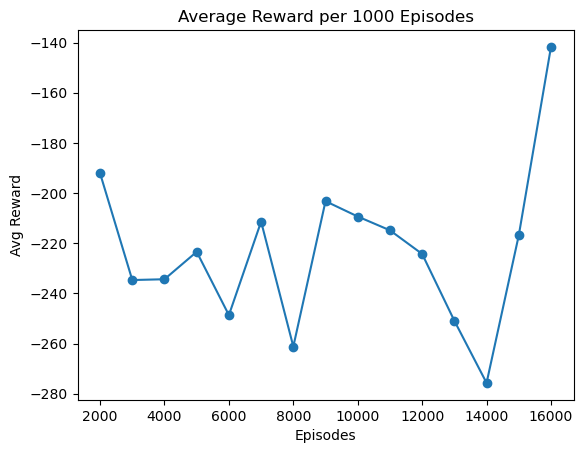

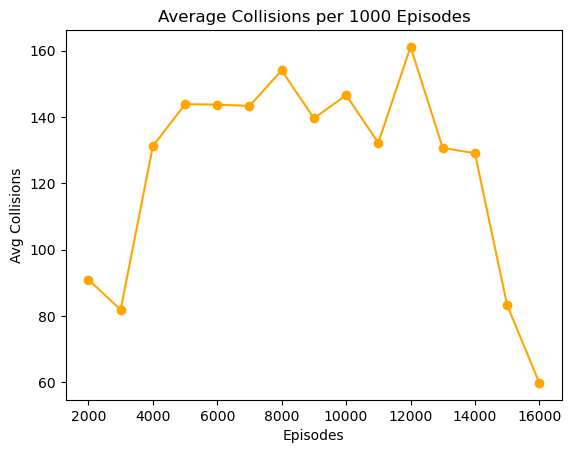

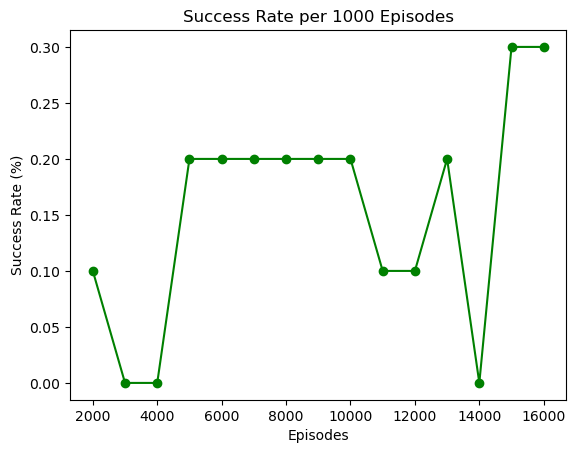

In [3]:
import matplotlib.pyplot as plt

# Data from each block of 1000 episodes (2000 to 16000 in increments of 1000)
episodes = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]

# Corresponding average reward for each block
avg_rewards = [
    -192.13, -234.69, -234.37, -223.43, -248.67,
    -211.40, -261.21, -203.25, -209.36, -214.86,
    -224.29, -250.92, -275.71, -216.87, -141.74
]

# Corresponding average collisions for each block
avg_collisions = [
    90.95, 81.86, 131.18, 143.85, 143.71,
    143.32, 154.04, 139.59, 146.55, 132.25,
    161.11, 130.68, 129.06, 83.26, 59.82
]

# Corresponding success rate (in %)
success_rates = [
    0.1, 0.0, 0.0, 0.2, 0.2,
    0.2, 0.2, 0.2, 0.2, 0.1,
    0.1, 0.2, 0.0, 0.3, 0.3
]

# 1) Plot Average Reward
plt.figure()
plt.plot(episodes, avg_rewards, marker='o')
plt.title("Average Reward per 1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Avg Reward")
plt.show()

# 2) Plot Average Collisions
plt.figure()
plt.plot(episodes, avg_collisions, marker='o', color='orange')
plt.title("Average Collisions per 1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Avg Collisions")
plt.show()

# 3) Plot Success Rate
plt.figure()
plt.plot(episodes, success_rates, marker='o', color='green')
plt.title("Success Rate per 1000 Episodes")
plt.xlabel("Episodes")
plt.ylabel("Success Rate (%)")
plt.show()

### Summary of Algorithms and Concepts in the Code

#### Environment Setup
- CARLA Client & World:
  - The function `setup_carla_client()` creates a CARLA client (connecting to `localhost:2000` with a 10-second timeout) and retrieves the simulation world.
- Vehicle and Actor Spawning:
  - Agent Vehicle:
    - `spawn_vehicle(world)` spawns a random vehicle using a blueprint from the CARLA blueprint library and places it at a random spawn point.
  - NPC Vehicles:
    - `spawn_npc_vehicles(client, world, num_vehicles)` spawns multiple non-player vehicles, shuffles the spawn points, and sets them to autopilot.
  - Pedestrians:
    - `spawn_pedestrians(world, num_pedestrians)` spawns a set number of pedestrian actors at random navigation locations.
- Sensors Attached to the Agent Vehicle:
  - Camera Sensor:
    - Attached via `attach_camera_sensor(world, vehicle)`.
    - Parameters: 384×256 image size, FOV 135°, sensor tick of 0.1 seconds.
  - Collision Sensor:
    - Attached using `attach_collision_sensor(world, vehicle, collision_callback)` to capture collision events.
  - LiDAR Sensor (Optional):
    - The code for LiDAR (via `attach_lidar_sensor()`, `lidar_callback()`, and `debug_lidar()`) is present as part of the original plan for obstacle detection.
  - Spectator Camera:
    - A spectator actor is used for visualization and is updated to maintain a fixed front view relative to the vehicle.

#### Hyperparameters
- The Adam optimizer is configured with a learning rate of 0.0001.
- Discount Factor: $\gamma = 0.9$. This factor discounts future rewards in the return computation.
- Rollout Length ($T_\text{max}$): Each rollout (episode segment) is 20 steps long.
- Replay Buffer:
  - Capacity: 100,000 transitions.
  - Off-policy update batch size: 256.
- Exploration Parameters (Epsilon-Greedy):
  - Starting epsilon: 1.0
  - Minimum epsilon: 0.2
  - Epsilon decay rate: 0.9999 per episode.
- Loss Coefficients:
  - Entropy Coefficient: 0.05 (to encourage exploration).
  - Value Loss Coefficient: 0.5.
- Reward Shaping: The reward function includes various terms:
  - Speed compliance rewards/penalties.
  - Large negative penalties for collisions.
  - Penalties for idling (being stuck) and excessive reverse time.
  - Bonuses for progress toward and reaching the destination.
  - Penalties for running red lights and deviating from lane/heading.
  - A repeated cycle penalty to discourage oscillatory actions.

#### Markov Decision Processes (MDPs)
  - State: $s \in S$ (camera images and optionally LiDAR grid).
  - Action: $a \in A$ (discrete vehicle control commands).
  - Reward: $r(s,a)$ computed via a reward function (speed, collisions, etc.).
  - Transition probability: $P(s'| s,a)$ (environment dynamics simulated by CARLA).
  - Discount factor: $\gamma \in [0,1]$
  - The goal is to find a policy $\pi(a|s)$ that maximizes the expected discounted return: $\\ $ $\large J(\theta) = \mathbb{E}_{\pi\theta}[\Sigma_{t=0}^\infty \gamma^t r_t]$

#### Actor-Critic Network:
  - A convolutional neural network (CNN) that extracts features from input images.
  - Outputs policy logits (for action selection) and a state value estimate.
  - Trained using gradient descent with Adam optimizer (adaptive learning rate).
  - The core decision-maker.
  - Policy (Actor): The network outputs logits, which are converted into a probability distribution via $\\ $ $\large\pi_\theta(a|s)=\frac{\exp(z_a)}{\Sigma_{a'}\exp(z_{a'})}$ where $z_a$ are the logits for each action $a$.
  - Value Function (Critic): $V(s)$ is the estimated value of state $s$.

#### TD Learning & Actor-Critic Methods
- TD Error:  
  - The difference between the bootstrapped multi-step return and the current value estimate.
  - The TD error is computed as: $A(s,a) = R - V(s)$ where $R$ is the multi-step return.
  - The policy gradient update is: $\nabla_\theta J(\theta) \approx \mathbb{E}[\nabla_\theta \log\pi_\theta (a|s)A(s,a)]$
- Policy Update:  
  - Uses the advantage (TD error) to weight the log-probability of actions.
  - Policy loss: $L_{\text{policy}} = -\log\pi_\theta(a|s)A(s,a)$
- Value Update:  
  - Minimizes the mean squared error between the estimated value and the computed return.
  - Value loss: $L_{\text{value}} = (V(s)-R)^2$
- To encourage exploration, add an entory term: $H(\pi_\theta(s)) = -\Sigma_a \pi_\theta (a|s)\log\pi_\theta (a|s)$
- Combined loss: $L = \Sigma_t (L_{\text{policy}}(s_t, a_t) + \beta L_{\text{value}}(s_t) - \alpha H(\pi_\theta(s_t)))$
  - $\beta$ is the value loss coefficient.
  - $\alpha$ is the entropy coefficient.
  
#### Rollout Collection:  
  - Collects a sequence of transitions (rollout) from the environment.
  - Computes multi-step returns via backward induction (blending Monte Carlo with bootstrapping).

#### Multi-Step Return Calculation:  
  - Uses backward induction to compute returns for each time step.
  - We compute the multi-step return $R_t$ for a rollout of length $n$ using: $\\ $ $R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots + \gamma^{n-1}r_{t+n-1} + \gamma^n V(s_{t+n})$
  - $R_t$ is used for both computing TD error and updating the value function (critic).
  - This is a dynamic programming approach applied in TD learning.

#### A\* Search: 
  - Implements global path planning on a grid.
  - Uses the Euclidean distance as a heuristic to guide the search: $\\ $ $h(n) = ||n - \text{ goal}||$
    - $h(n)$ is a heuristic estimate of the cost from node $n$ to the goal.
    - $g(n)$ is the cost from start node to node $n$.
  - Evaluation function: $f(n) = g(n) + h(n)$
    - A\* then selects the node with the smallest $f(n)$ until reaching the goal.
  - Demonstrates informed search with heuristic guidance.
  
#### Stochasticity and Exploration (Bandits)
- Stochastic Policy: actions are sampled from a softmax distribution derived from network logits.
- Epsilon-Greedy Strategy: adds randomness to action selection to ensure exploration.
  - With probability $epsilon$, choose a random action.
  - With probability $1-\epsilon$, choose the action with the highest probability.
  
#### Reward Function as Constraint
  - Incorporates speed limits, collision penalties, red light compliance, and lane-keeping as constraints.
  - These constraints guide the agent’s behavior similar to rules in a game.
  
#### LiDAR for Obstacle Detection  
  - Originally planned to use LiDAR data for building an obstacle grid.
  - Used in conjunction with A\* search for global route planning (currently commented out or not actively used).

#### In summary, this Python script does:
- It initializes a CARLA client, spawns vehicles, NPCs, and pedestrians, and attaches sensors to the agent's vehicle.
- An Actor–Critic network (A3C) processes camera images to output control commands. This network is trained via reinforcement learning using TD learning and multi-step returns.
- Reinforcement Learning Framework: The agent learns through rollouts where it collects transitions (state, action, reward, etc.) and then updates its policy using a combination of policy gradients and value function updates. It uses prioritized experience replay to sample important transitions more frequently.
- The code includes an A* search algorithm that can compute a global path based on a grid of obstacles. Although LiDAR-based obstacle detection is part of the original plan, that section may or may not be working as intended currently.
- The training loop computes evaluation metrics, saves model checkpoints, and plots reward graphs. It includes memory management (like GPU cache clearing and garbage collection) to prevent crashes during extended training.